This model will predict the Length Of Stay (LOS) of patients.

In [1]:
import torch
import matplotlib.pyplot as plt
from torch import nn, optim
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, Dataset

In [2]:
df = pd.read_csv('data/HealthCareAnalytics/train.csv')

In [3]:
df.head()

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,1,8,c,3,Z,3,radiotherapy,R,F,2.0,31397,7.0,Emergency,Extreme,2,51-60,4911.0,0-10
1,2,2,c,5,Z,2,radiotherapy,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,5954.0,41-50
2,3,10,e,1,X,2,anesthesia,S,E,2.0,31397,7.0,Trauma,Extreme,2,51-60,4745.0,31-40
3,4,26,b,2,Y,2,radiotherapy,R,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,7272.0,41-50
4,5,26,b,2,Y,2,radiotherapy,S,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,5558.0,41-50


Things I am considering to remove: case_id, patientid

In [4]:
df['City_Code_Patient'].unique()

array([ 7.,  8.,  2.,  5.,  6.,  3.,  4.,  1.,  9., 14., nan, 25., 15.,
       12., 10., 28., 24., 23., 20., 11., 13., 21., 18., 16., 26., 27.,
       22., 19., 31., 34., 32., 30., 29., 37., 33., 35., 36., 38.])

In [5]:
df = df.drop(columns=['case_id', 'patientid'])

In [6]:
df.shape

(318438, 16)

In [7]:
print(df['Stay'].unique())
print(type(df['Stay'][0]))

['0-10' '41-50' '31-40' '11-20' '51-60' '21-30' '71-80'
 'More than 100 Days' '81-90' '61-70' '91-100']
<class 'str'>


There are 11 possible lengths of stay.

The next step is to make all of the data "readable to the computer" (i.e. clean it up). 

In [8]:
df['City_Code_Patient'].unique()

array([ 7.,  8.,  2.,  5.,  6.,  3.,  4.,  1.,  9., 14., nan, 25., 15.,
       12., 10., 28., 24., 23., 20., 11., 13., 21., 18., 16., 26., 27.,
       22., 19., 31., 34., 32., 30., 29., 37., 33., 35., 36., 38.])

In [9]:
df['Admission_Deposit'].unique()

array([4911., 5954., 4745., ..., 1937., 9439., 2349.])

In [10]:
df = df.rename(columns={'Severity of Illness': "Severity_of_Illness"})

In [11]:
independent_columns = []
stay_range_list = ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100', 'More than 100 Days']

def codify_columns(df):
    for label in df.keys():
        if label != 'Stay' and label != 'S_unique' and 'unique' not in label:
            print(label, ", ", df[label].dtype)
            if df[label].unique().dtype == 'O':
                name = label[0]
                for part in label.split('_')[1:]:
                    name += part[0] 
                name += "_unique"

                df[name] = df[label].astype('category').cat.codes
                independent_columns.append(name)
            else:
                independent_columns.append(label)
                df[label] = df[label].fillna(df[label].mode()[0])
                df[label] = df[label].astype('float')
        elif label == 'Stay':
            df['S_unique'] = df['Stay'].apply(lambda x: stay_range_list.index(x))

codify_columns(df)

Hospital_code ,  int64
Hospital_type_code ,  object
City_Code_Hospital ,  int64
Hospital_region_code ,  object
Available Extra Rooms in Hospital ,  int64
Department ,  object
Ward_Type ,  object
Ward_Facility_Code ,  object
Bed Grade ,  float64
City_Code_Patient ,  float64
Type of Admission ,  object
Severity_of_Illness ,  object
Visitors with Patient ,  int64
Age ,  object
Admission_Deposit ,  float64


In [12]:
print(df['S_unique'].head())
print(df["Stay"].head())
print(df['Stay'].shape)

0    0
1    4
2    3
3    4
4    4
Name: S_unique, dtype: int64
0     0-10
1    41-50
2    31-40
3    41-50
4    41-50
Name: Stay, dtype: object
(318438,)


In [13]:
df.keys()

Index(['Hospital_code', 'Hospital_type_code', 'City_Code_Hospital',
       'Hospital_region_code', 'Available Extra Rooms in Hospital',
       'Department', 'Ward_Type', 'Ward_Facility_Code', 'Bed Grade',
       'City_Code_Patient', 'Type of Admission', 'Severity_of_Illness',
       'Visitors with Patient', 'Age', 'Admission_Deposit', 'Stay',
       'Htc_unique', 'Hrc_unique', 'D_unique', 'WT_unique', 'WFC_unique',
       'T_unique', 'SoI_unique', 'A_unique', 'S_unique'],
      dtype='object')

In [14]:
df.isna().any()

Hospital_code                        False
Hospital_type_code                   False
City_Code_Hospital                   False
Hospital_region_code                 False
Available Extra Rooms in Hospital    False
Department                           False
Ward_Type                            False
Ward_Facility_Code                   False
Bed Grade                            False
City_Code_Patient                    False
Type of Admission                    False
Severity_of_Illness                  False
Visitors with Patient                False
Age                                  False
Admission_Deposit                    False
Stay                                 False
Htc_unique                           False
Hrc_unique                           False
D_unique                             False
WT_unique                            False
WFC_unique                           False
T_unique                             False
SoI_unique                           False
A_unique   

I noticed something. When encoding the data I set a unique value to the Nan values in Bed Grade and City_Code_Patient. This might affect the data, but I believe it will be alright. The alternative will be making sure that when encoding, the nan values are set to the mode value.

In [15]:
print(df.shape[0])

318438


In [16]:
df['S_unique']

0         0
1         4
2         3
3         4
4         4
         ..
318433    1
318434    3
318435    1
318436    1
318437    0
Name: S_unique, Length: 318438, dtype: int64

In [17]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)


print("Training Set:")
print(train_df.shape)
print("\nTesting Set:")
print(test_df.shape)

Training Set:
(254750, 25)

Testing Set:
(63688, 25)


In [18]:
class Data(Dataset):
    def __init__(self, df, train=True):
        self.y = 0
        if train:
            self.y = torch.tensor(df['S_unique'].values, dtype=torch.long)
        self.x = torch.tensor(df[independent_columns].values, dtype=torch.float)
        self.len = df.shape[0]
        self.train = train
    
    def __len__(self):
        return self.len
    
    def __getitem__(self, index):
        if self.train:
            return self.x[index], self.y[index]
        return self.x[index]
    
train_data = Data(train_df)

In [19]:
x, y = train_data[0]
print(x.shape)
print(y.shape)
print(y)
print(x.dtype)

print(x)


torch.Size([15])
torch.Size([])
tensor(2)
torch.float32
tensor([1.9000e+01, 0.0000e+00, 7.0000e+00, 1.0000e+00, 4.0000e+00, 2.0000e+00,
        1.0000e+00, 2.0000e+00, 2.0000e+00, 8.0000e+00, 0.0000e+00, 2.0000e+00,
        4.0000e+00, 4.0000e+00, 6.2470e+03])


In [207]:
class SoftMax(nn.Module):
    def __init__(self, input_size, middle_size, middle_size2, output_size):
        super(SoftMax, self).__init__()
        self.linear1 = nn.Linear(in_features=input_size, out_features=middle_size)
        self.linear2 = nn.Linear(in_features=middle_size, out_features=middle_size2)
        self.linear3 = nn.Linear(in_features=middle_size2, out_features=output_size)

    def forward(self, x):
        l1 = self.linear1(x)
        return self.linear2(l1)
    
model = SoftMax(15, 14, 12, 11)

In [220]:
learning_rate = 0.005
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
train_data_loader = DataLoader(train_data, batch_size=500)
criterion = nn.CrossEntropyLoss()

In [221]:
epochs = 10
LOSS = []

def train_model(epochs):
    for epoch in range(epochs):
        for x,y in train_data_loader:
            x = x.float()
            y = y.long() 
            optimizer.zero_grad()
            yhat = model(x)
            loss = criterion(yhat, y)
            LOSS.append(loss.item())
            loss.backward()
            optimizer.step()

train_model(epochs)

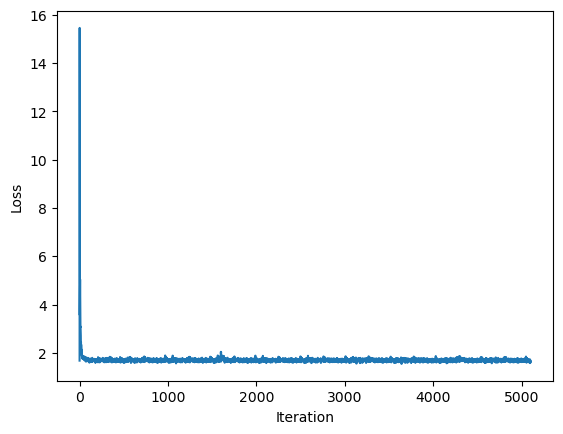

In [222]:
plt.plot(LOSS)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

In [223]:
test_data = Data(test_df)
test_loader = DataLoader(test_data, batch_size=100)

predicted = []
actual = []

with torch.no_grad():
    for x, y in test_loader:
        yhat = model(x)
        _, max_indices = torch.max(yhat, dim=1)
        print(max_indices)
        predicted.extend(max_indices.tolist())
        actual.extend(y.tolist())


tensor([ 1,  3,  2,  1,  2,  1,  5,  2,  2,  2,  3,  2,  3,  2,  5,  1,  3,  1,
         1,  2,  3,  3,  2,  2,  3,  2,  1,  3,  2,  3,  5,  1,  3,  2,  5,  5,
         1,  1,  2,  1,  3,  1,  1,  2,  3,  1,  2,  3,  2,  2,  1,  3,  1,  3,
         3, 10,  1,  5,  2,  1,  2,  3,  1,  3,  1,  1,  1,  2,  2,  1,  3,  3,
         1,  2,  2,  1,  1,  2,  1,  2,  3,  1,  2,  2,  3,  2,  5,  1,  2,  5,
         1, 10,  1,  5,  3,  2,  1, 10,  2,  1])
tensor([ 2,  2,  2,  5,  5,  3,  2,  1,  2,  1,  1,  3,  3,  1,  5,  2,  2,  1,
         2,  3,  2,  1,  2,  2,  2,  2,  2,  1,  2,  1,  2,  1,  1,  1,  2,  5,
         3,  5,  1,  1,  1,  5,  5,  3,  1,  1,  1,  1,  1,  2,  1,  3,  2,  5,
         5,  2,  1,  1,  2,  1,  2, 10,  3,  2,  1,  1,  1,  2,  1,  1,  1,  2,
         3,  1,  5,  2,  2,  2,  1,  2,  2,  2,  2,  3,  1,  3,  2,  2,  2,  1,
         2,  3,  2,  3,  2,  2,  3,  1,  1,  1])
tensor([ 2,  1,  2,  2,  2,  1,  5,  2,  3,  5,  2,  2,  2,  1,  1,  2,  1,  5,
         1,  1,  1,  1

In [224]:
# print(predicted[0])
print("first len: ")
print((predicted))


print(actual)

first len: 
[1, 3, 2, 1, 2, 1, 5, 2, 2, 2, 3, 2, 3, 2, 5, 1, 3, 1, 1, 2, 3, 3, 2, 2, 3, 2, 1, 3, 2, 3, 5, 1, 3, 2, 5, 5, 1, 1, 2, 1, 3, 1, 1, 2, 3, 1, 2, 3, 2, 2, 1, 3, 1, 3, 3, 10, 1, 5, 2, 1, 2, 3, 1, 3, 1, 1, 1, 2, 2, 1, 3, 3, 1, 2, 2, 1, 1, 2, 1, 2, 3, 1, 2, 2, 3, 2, 5, 1, 2, 5, 1, 10, 1, 5, 3, 2, 1, 10, 2, 1, 2, 2, 2, 5, 5, 3, 2, 1, 2, 1, 1, 3, 3, 1, 5, 2, 2, 1, 2, 3, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 2, 1, 1, 1, 2, 5, 3, 5, 1, 1, 1, 5, 5, 3, 1, 1, 1, 1, 1, 2, 1, 3, 2, 5, 5, 2, 1, 1, 2, 1, 2, 10, 3, 2, 1, 1, 1, 2, 1, 1, 1, 2, 3, 1, 5, 2, 2, 2, 1, 2, 2, 2, 2, 3, 1, 3, 2, 2, 2, 1, 2, 3, 2, 3, 2, 2, 3, 1, 1, 1, 2, 1, 2, 2, 2, 1, 5, 2, 3, 5, 2, 2, 2, 1, 1, 2, 1, 5, 1, 1, 1, 1, 2, 2, 5, 5, 2, 2, 2, 2, 3, 1, 3, 2, 3, 5, 3, 1, 2, 2, 2, 5, 1, 2, 2, 2, 2, 5, 2, 1, 5, 2, 2, 1, 1, 1, 2, 1, 2, 3, 2, 2, 5, 2, 3, 3, 5, 5, 3, 1, 3, 2, 10, 2, 3, 2, 5, 1, 2, 2, 1, 2, 1, 2, 2, 2, 1, 3, 2, 3, 1, 2, 10, 1, 2, 1, 5, 2, 2, 0, 2, 5, 3, 3, 2, 1, 1, 3, 1, 2, 2, 1, 1, 2, 0, 2, 1, 1, 2, 3, 1, 3, 2, 5, 2, 2, 2, 

In [225]:
total_test_cases = test_data.len
number_of_errors = 0

for i in range(total_test_cases):
    if predicted[i] != actual[i]:
        number_of_errors += 1

print("Error percentage: ", number_of_errors/total_test_cases)

Error percentage:  0.6288782816229117


I reached a point where I could not get past error rate of 63%. I am going to try to normalize the data of the columns.